In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from efficientkan import KAN

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors and scale to [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [ ]:
class MyMLP(nn.Module):

    def __init__(self, layers: list):
        super(MyMLP, self).__init__()

        to_sequential, self.num_parameters = self.build_layers_and_count_params(layers)
        self.layers = nn.Sequential(*to_sequential)

    def forward(self, x):
        return self.layers(x)


    # given a list of layer sizes, builds the respective linear layers with ReLU activation functions.
    # Also returns the total number of parameters of the model.
    def build_layers_and_count_params(self, layers):

        to_sequential = []
        num_parameters = 0

        for i in range(len(layers) - 1):

            to_sequential.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                to_sequential.append(nn.ReLU())

            num_parameters += layers[i]*layers[i+1] + layers[i+1]

        return to_sequential, num_parameters




class MyKAN(nn.Module):

    def __init__(self, layers: list, grid_size):
        super(MyKAN, self).__init__()

        self.num_parameters = self.count_params(layers, grid_size)
        self.layers = KAN(layers, grid_size=grid_size)


    def forward(self, x):
        return self.layers(x)


    def count_params(self, layers, grid_size):

        num_parameters = 0

        for i in range(len(layers) - 1):
            num_parameters += layers[i]*layers[i+1]

        return num_parameters * grid_size

In [ ]:
def train_and_evaluate(model, trainloader, valloader, device, num_epochs, optimizer, criterion):

    lr = optimizer.param_groups[0]['lr']
    print(f'Training model "{model.__class__.__name__}" with device: {device} and parameters:' if device=='cpu' else f'Training model "{model.__class__.__name__}" with device: {device} ({torch.cuda.get_device_name()}) and parameters:')
    print(f'\tLearning rate: {lr}\n\tLoss function: {criterion}\n\tOptimizer: {optimizer.__class__.__name__}\n')
    print(f'Number of parameters: {model.num_parameters}\n')

    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []

    for epoch in range(num_epochs):

# Train
        model.train()
        train_loss = 0
        train_acc = 0

        start = time()

        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)

                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                train_acc += accuracy.item()

        train_losses.append(train_loss / i)
        train_accs.append(train_acc / i)

        t = time()-start
        times.append(t)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / i:.4f}, Train Accuracy: {train_acc / i:.4f}, Time: {t:.2f}s")


# Validation
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(valloader):
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)

                val_loss += criterion(output, labels.to(device)).item()
                val_acc += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())

        val_losses.append(val_loss / i)
        val_accs.append(val_acc / i)

        print(f"\t      Valid Loss: {val_loss / i:.4f}, Valid Accuracy: {val_acc / i:.4f}\n")


    return train_losses, train_accs, val_losses, val_accs, times

In [ ]:
# Define models and parameters

model_list_mlp = [
    MyMLP([28*28, 128, 10]),
    MyMLP([28*28, 64, 10]),
    MyMLP([28*28, 10, 10]),
    MyMLP([28*28, 10, 10, 10]),
    MyMLP([28*28, 5, 5, 10])
    ]
model_list_kan = [
    MyKAN([28*28, 64, 10], grid_size=3),
    MyKAN([28*28, 10, 10], grid_size=3),
    MyKAN([28*28, 5, 10], grid_size=3),
    MyKAN([28*28, 10, 10, 10], grid_size=3),
    MyKAN([28*28, 5, 5, 10], grid_size=3)
    ]
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

num_epochs = 2
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

df_mlp = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
df_kan = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
separator = pd.DataFrame({'Epoch' : ['---'], 'Loss (t)' : ['---'], 'Loss (v)': ['---'], 'Accuracy (t)': ['---'], 'Accuracy (v)': ['---'], 'Time': ['---']})

for model_mlp, model_kan in zip(model_list_mlp, model_list_kan):

    optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
    train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp = train_and_evaluate(model_mlp, trainloader, valloader, device, num_epochs, optimizer_mlp, criterion)

    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan = train_and_evaluate(model_kan, trainloader, valloader, device, num_epochs, optimizer_kan, criterion)

    single_df_mlp = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses_mlp],
        'Loss (v)': [i for i in val_losses_mlp],
        'Accuracy (t)': [i for i in train_accs_mlp],
        'Accuracy (v)': [i for i in val_accs_mlp],
        'Time': [i for i in time_mlp]
        })

    single_df_kan = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses_kan],
        'Loss (v)': [i for i in val_losses_kan],
        'Accuracy (t)': [i for i in train_accs_kan],
        'Accuracy (v)': [i for i in val_accs_kan],
        'Time': [i for i in time_kan]
        })

    means_mlp = {'Epoch': 'Mean', 'Time': single_df_mlp['Time'].mean()}
    means_kan = {'Epoch': 'Mean', 'Time': single_df_kan['Time'].mean()}

    num_params_mlp = {'Epoch': f'Params: {model_mlp.num_parameters}'}
    num_params_kan = {'Epoch': f'Params: {model_kan.num_parameters}'}

    single_df_mlp = pd.concat([single_df_mlp, pd.DataFrame([means_mlp])], ignore_index=True)
    single_df_mlp = pd.concat([single_df_mlp, pd.DataFrame([num_params_mlp])], ignore_index=True)
    single_df_mlp = pd.concat([single_df_mlp, separator], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, pd.DataFrame([means_kan])], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, pd.DataFrame([num_params_kan])], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, separator], ignore_index=True)

    df_mlp = pd.concat([df_mlp, single_df_mlp], ignore_index=True)
    df_kan = pd.concat([df_kan, single_df_kan], ignore_index=True)

Training model "MyMLP" with device: cpu and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 101770



100%|██████████| 938/938 [00:27<00:00, 33.70it/s]


Epoch [1/2], Train Loss: 0.3852, Train Accuracy: 0.8881, Time: 27.84s
	      Valid Loss: 0.2301, Valid Accuracy: 0.9405



100%|██████████| 938/938 [00:20<00:00, 46.15it/s]


Epoch [2/2], Train Loss: 0.2017, Train Accuracy: 0.9418, Time: 20.34s
	      Valid Loss: 0.1613, Valid Accuracy: 0.9575

Training model "MyKAN" with device: cpu and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 152448



100%|██████████| 938/938 [00:42<00:00, 22.29it/s]


Epoch [1/2], Train Loss: 0.3865, Train Accuracy: 0.8913, Time: 42.08s
	      Valid Loss: 0.2280, Valid Accuracy: 0.9411



100%|██████████| 938/938 [00:43<00:00, 21.62it/s]


Epoch [2/2], Train Loss: 0.1812, Train Accuracy: 0.9484, Time: 43.38s
	      Valid Loss: 0.1556, Valid Accuracy: 0.9618

Training model "MyMLP" with device: cpu and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 50890



100%|██████████| 938/938 [00:19<00:00, 48.62it/s]


Epoch [1/2], Train Loss: 0.4303, Train Accuracy: 0.8773, Time: 19.30s
	      Valid Loss: 0.2676, Valid Accuracy: 0.9303



100%|██████████| 938/938 [00:20<00:00, 46.74it/s]


Epoch [2/2], Train Loss: 0.2487, Train Accuracy: 0.9274, Time: 20.08s
	      Valid Loss: 0.1949, Valid Accuracy: 0.9505

Training model "MyKAN" with device: cpu and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 23820



100%|██████████| 938/938 [00:34<00:00, 27.02it/s]


Epoch [1/2], Train Loss: 0.5573, Train Accuracy: 0.8434, Time: 34.73s
	      Valid Loss: 0.3125, Valid Accuracy: 0.9199



100%|██████████| 938/938 [00:35<00:00, 26.28it/s]


Epoch [2/2], Train Loss: 0.2905, Train Accuracy: 0.9189, Time: 35.70s
	      Valid Loss: 0.2745, Valid Accuracy: 0.9300

Training model "MyMLP" with device: cpu and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 7960



100%|██████████| 938/938 [00:19<00:00, 49.13it/s]


Epoch [1/2], Train Loss: 0.8390, Train Accuracy: 0.7348, Time: 19.10s
	      Valid Loss: 0.4720, Valid Accuracy: 0.8694



100%|██████████| 938/938 [00:18<00:00, 51.30it/s]


Epoch [2/2], Train Loss: 0.4624, Train Accuracy: 0.8665, Time: 18.29s
	      Valid Loss: 0.4077, Valid Accuracy: 0.8880

Training model "MyKAN" with device: cpu and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11910



100%|██████████| 938/938 [00:36<00:00, 25.89it/s]


Epoch [1/2], Train Loss: 0.8018, Train Accuracy: 0.7617, Time: 36.23s
	      Valid Loss: 0.4939, Valid Accuracy: 0.8630



100%|██████████| 938/938 [00:34<00:00, 26.96it/s]


Epoch [2/2], Train Loss: 0.4634, Train Accuracy: 0.8685, Time: 34.80s
	      Valid Loss: 0.4236, Valid Accuracy: 0.8859

Training model "MyMLP" with device: cpu and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 8070



100%|██████████| 938/938 [00:19<00:00, 48.36it/s]


Epoch [1/2], Train Loss: 0.7630, Train Accuracy: 0.7619, Time: 19.40s
	      Valid Loss: 0.4407, Valid Accuracy: 0.8730



100%|██████████| 938/938 [00:18<00:00, 50.91it/s]


Epoch [2/2], Train Loss: 0.4094, Train Accuracy: 0.8798, Time: 18.43s
	      Valid Loss: 0.3903, Valid Accuracy: 0.8909

Training model "MyKAN" with device: cpu and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 24120



100%|██████████| 938/938 [00:37<00:00, 24.96it/s]


Epoch [1/2], Train Loss: 0.6269, Train Accuracy: 0.8119, Time: 37.59s
	      Valid Loss: 0.3335, Valid Accuracy: 0.9118



100%|██████████| 938/938 [00:37<00:00, 24.82it/s]


Epoch [2/2], Train Loss: 0.3041, Train Accuracy: 0.9134, Time: 37.81s
	      Valid Loss: 0.2727, Valid Accuracy: 0.9303

Training model "MyMLP" with device: cpu and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 4015



100%|██████████| 938/938 [00:18<00:00, 50.77it/s]


Epoch [1/2], Train Loss: 1.6270, Train Accuracy: 0.4075, Time: 18.48s
	      Valid Loss: 1.3632, Valid Accuracy: 0.4990



100%|██████████| 938/938 [00:19<00:00, 48.14it/s]


Epoch [2/2], Train Loss: 1.3098, Train Accuracy: 0.5046, Time: 19.49s
	      Valid Loss: 1.2474, Valid Accuracy: 0.5332

Training model "MyKAN" with device: cpu and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11985



100%|██████████| 938/938 [00:36<00:00, 25.37it/s]


Epoch [1/2], Train Loss: 1.1218, Train Accuracy: 0.6359, Time: 36.97s
	      Valid Loss: 0.6753, Valid Accuracy: 0.8094



100%|██████████| 938/938 [00:37<00:00, 25.34it/s]


Epoch [2/2], Train Loss: 0.5893, Train Accuracy: 0.8270, Time: 37.02s
	      Valid Loss: 0.5253, Valid Accuracy: 0.8531



In [ ]:
#print(df_mlp)
df_mlp.to_csv('results_mlp.csv', index = False)
df_kan.to_csv('results_kan.csv', index = False)

Plotting MLP

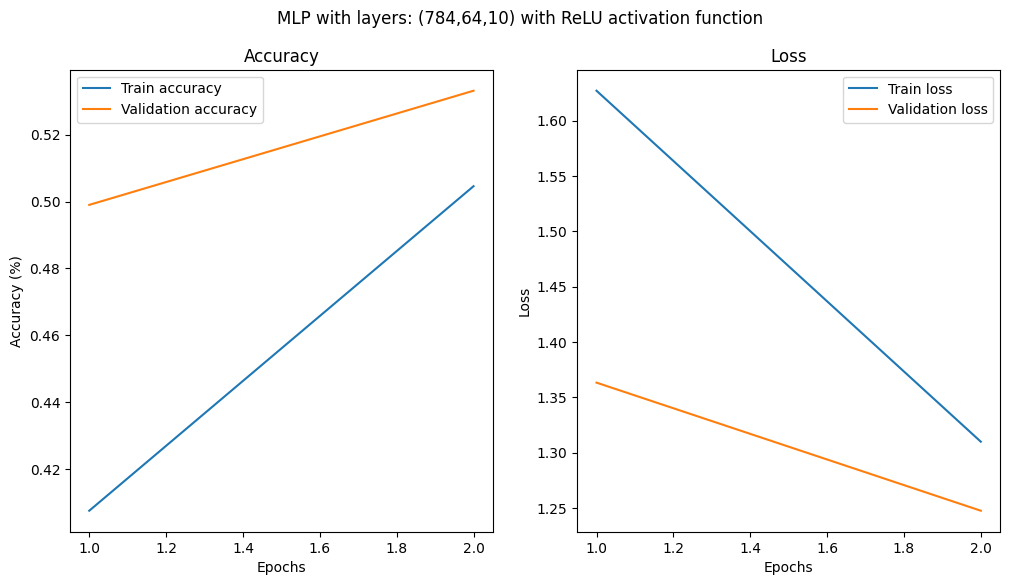

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_mlp, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_mlp, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_mlp, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_mlp, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('MLP with layers: (784,64,10) with ReLU activation function')
fig.show()

Plotting KAN

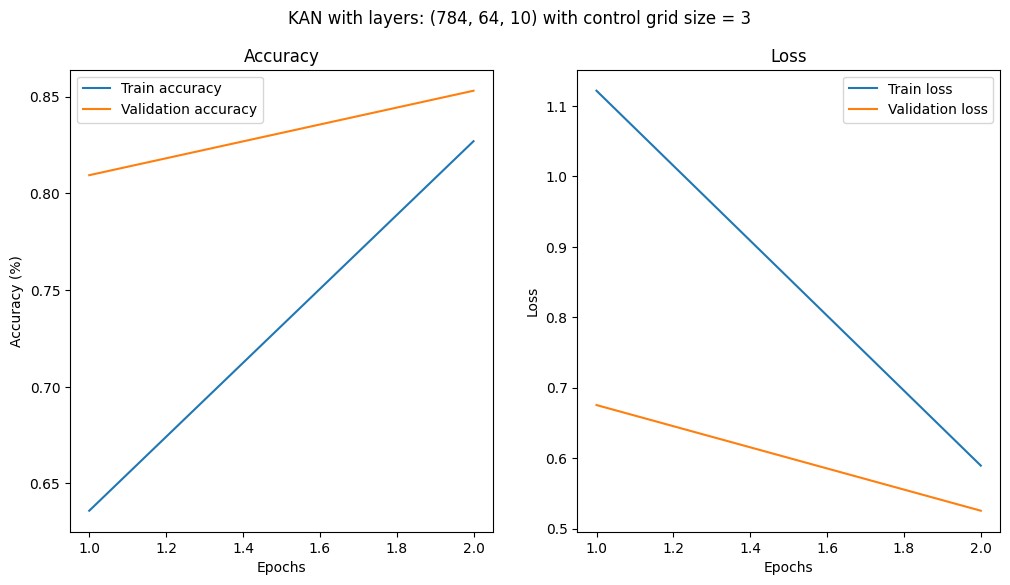

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_kan, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_kan, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_kan, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_kan, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('KAN with layers: (784, 64, 10) with control grid size = 3')
fig.show()